<a href="https://www.kaggle.com/code/tommasofacchin/tiktok-migration-sentiment-analysis?scriptVersionId=265369987" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **University Project (Social Network Analysis) - TikTok migration on RedNote**

For this project i will start by getting the data from reddit.

In [1]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 4.1 MB/s eta 0:00:00


In [2]:
import praw
import pandas as pd

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# Reddit API config.
reddit = praw.Reddit(
    client_id = user_secrets.get_secret("REDDIT_CLIENT_ID"),
    client_secret = user_secrets.get_secret("REDDIT_CLIENT_SECRET"),
    user_agent = user_secrets.get_secret("REDDIT_USER_AGENT")
)

# some parameters
subreddit_name = "TikTok"  
keywords = ["ban", "banning", "TikTok ban", "TikTok USA", "banned in USA", "government ban"]

In [3]:
import time
# Extract the data
posts_data = []

def extract_posts(subreddit_name, keywords):
    for keyword in keywords:
        
        for post in reddit.subreddit(subreddit_name).search(keyword, limit=None, sort="new"):
            # Post data
            post_data = [
                post.id, post.title, post.selftext, post.author.name if post.author else "Unknown",
                post.score, post.num_comments, post.upvote_ratio, post.created_utc, post.url, 'post',
                None, None, None, None, None, None
            ]
            posts_data.append(post_data)
            
            time.sleep(1)
            
            # Comment data
            post.comments.replace_more(limit=0)
            for comment in post.comments.list():
                comment_data = [
                    post.id, post.title, post.selftext, post.author.name if post.author else "Unknown",
                    post.score, post.num_comments, post.upvote_ratio, post.created_utc, post.url, 'comment',
                    comment.id, comment.author.name if comment.author else "Unknown",
                    comment.body, comment.score, comment.created_utc, comment.parent_id
                ]
                posts_data.append(comment_data)
            
# This takes a while
#extract_posts(subreddit_name, keywords)

In [4]:
# Convert to DataFrame
df = pd.DataFrame(posts_data, columns=[
    "post_id", "title", "text", "post_author", "score", "num_comments", 
    "upvote_ratio", "created_utc", "url", "type", "comment_id", "comment_author",
    "comment_body", "comment_score", "comment_created_utc", "parent_id"
])

#df.to_csv("reddit.csv", index=False)

In [5]:
import pandas as pd

df = pd.read_csv("/kaggle/input/reddit-tiktok-migration-csv/reddit.csv")

df.dropna(subset=['comment_body', 'comment_author'], inplace=True)

df['comment_author'] = df['comment_author'].astype(str).str.strip().str.lower()
df['post_author'] = df['post_author'].astype(str).str.strip().str.lower()

df = df[(df['comment_author'] != "unknown") & (df['post_author'] != "unknown")]

df['comment_created_utc'] = pd.to_datetime(df['comment_created_utc'], unit='s')
df = df[df['comment_created_utc'] >= "2024-01-01"]
df['date'] = df['comment_created_utc'].dt.date

print(df.shape)
df.head()

(16076, 17)


post_id                                              title  \
2  1j6vszp                                     Warning Strick   
3  1j6vszp                                     Warning Strick   
5  1j6pg3t  TikTok usage and spend fall as United States o...   
6  1j6pg3t  TikTok usage and spend fall as United States o...   
7  1j6pg3t  TikTok usage and spend fall as United States o...   

                                                text           post_author  \
2  So recently, I racked up several community vio...  equivalentradish9189   
3  So recently, I racked up several community vio...  equivalentradish9189   
5                                                NaN  novel_negotiation224   
6                                                NaN  novel_negotiation224   
7                                                NaN  novel_negotiation224   

   score  num_comments  upvote_ratio   created_utc  \
2      1             5          0.60  1.741482e+09   
3      1             5          0.60  1.741482e+09   
5    123            56          0.88  1.741464e+09   
6    123            56          0.88  1.741464e+09   
7    123            56          0.88  1.741464e+09   

                                                 url     type comment_id  \
2  https://www.reddit.com/r/TikTok/comments/1j6vs...  comment    mgsvr2r   
3  https://www.reddit.com/r/TikTok/comments/1j6vs...  comment    mgwyzib   
5  https://digiday.com/marketing/digiday-research...  comment    mgqw56h   
6  https://digiday.com/marketing/digiday-research...  comment    mgr9s8f   
7  https://digiday.com/marketing/digiday-research...  comment    mgrafxi   

         comment_author                                       comment_body  \
2             gosebajwo  Depends since you get another community violat...   
3  equivalentradish9189  I think I had eight community violations befor...   
5               zinky30                             Paywall. Useless post.   
6            footmitten                   It never recovered from the ban.   
7         lostandnotfnd  i still use it same as i did before just looki...   

   comment_score comment_created_utc   parent_id        date  
2            1.0 2025-03-09 04:25:09  t3_1j6vszp  2025-03-09  
3            1.0 2025-03-09 21:07:52  t1_mgsvr2r  2025-03-09  
5           42.0 2025-03-08 21:15:23  t3_1j6pg3t  2025-03-08  
6           41.0 2025-03-08 22:30:11  t3_1j6pg3t  2025-03-08  
7           16.0 2025-03-08 22:33:51  t3_1j6pg3t  2025-03-08

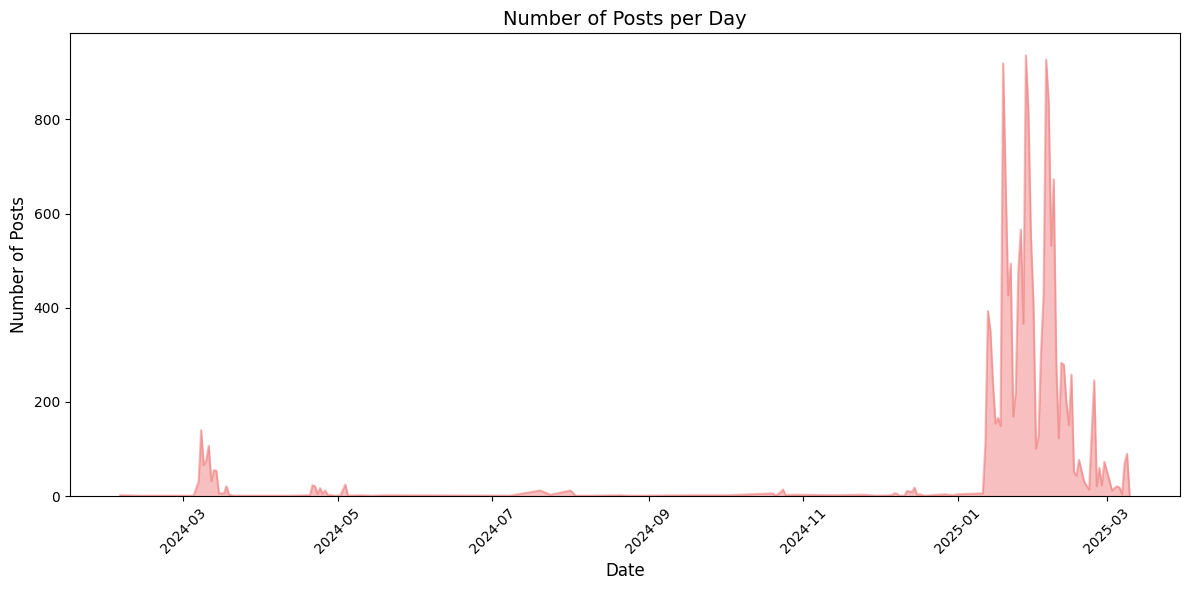

In [6]:
import matplotlib.pyplot as plt

df_date = df
df_date = df_date[df_date['comment_created_utc'].dt.year > 2023]
posts_per_day = df_date.groupby('date').size()

plt.figure(figsize=(12,6))
posts_per_day.plot(kind='area', color='lightcoral', alpha=0.5)
plt.title('Number of Posts per Day', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/kaggle/working/NumberOfPostsPerDay.png', dpi=300)
plt.show()

We can se some posts between March and May 2024, when President Biden first announced the TikTok ban in the US.
<br>Then, in January 2025, the app was actually banned.

<br> Let's now try to plot the graph, I will filter for degree centrality and betweenness centrality to see which one looks more suitable for this analysis.

# **Graphs**

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

for index, row in df.iterrows():
    user = row['comment_author']
    post_author = row['post_author']
    
    if user != post_author: 
        G.add_edge(user, post_author)


print("Number of nodes (users):", len(G.nodes))
print("Number of edges (interactions):", len(G.edges))

Number of nodes (users): 4252
Number of edges (interactions): 4691


N of nodes/edges original graph: 4252/4691
N of nodes/edges Degree Centrality : 161/185
N of nodes/edges Betweenness Centrality : 122/206


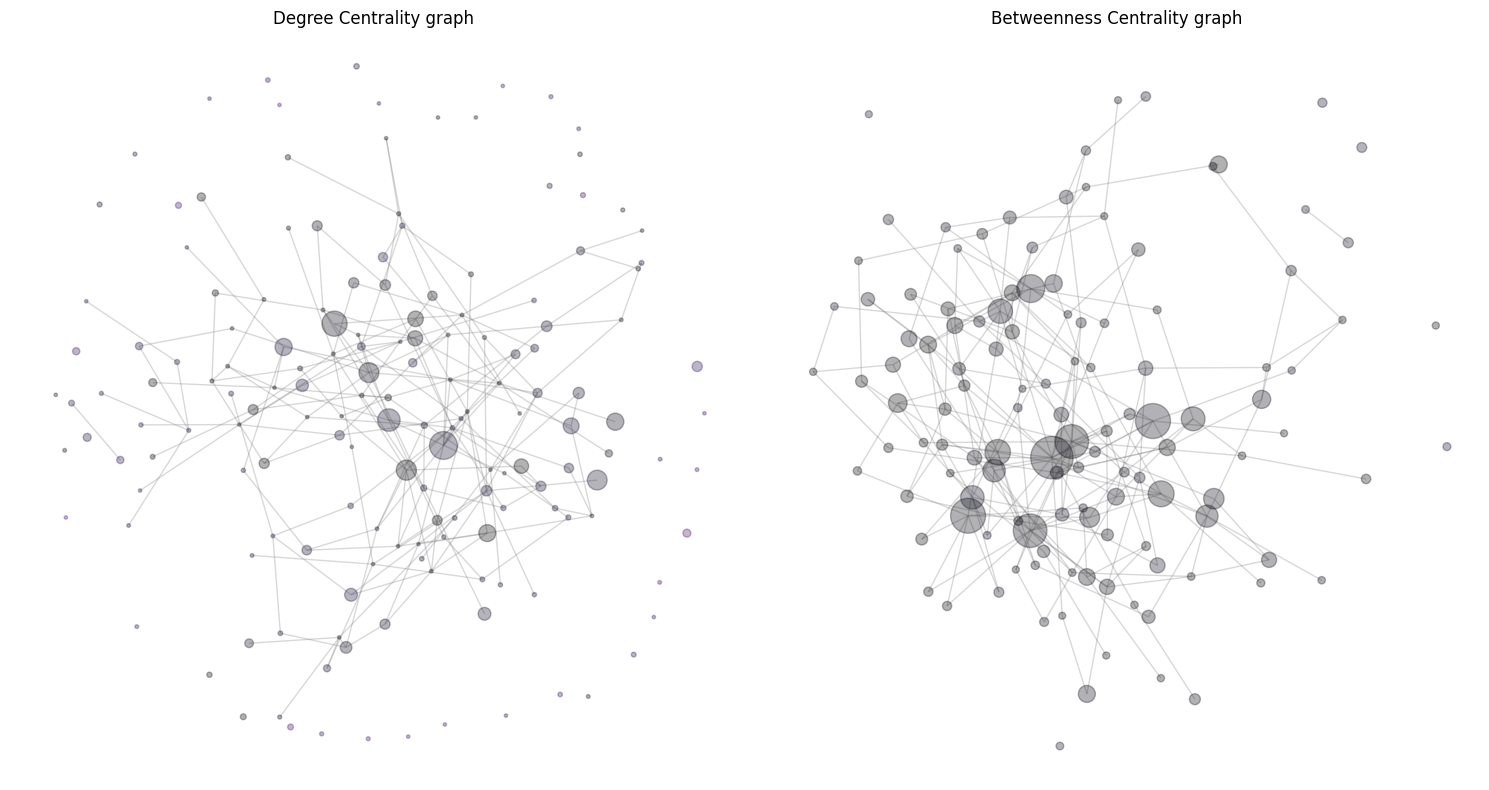

In [8]:
import community as community_louvain
import matplotlib

# 1. Degree Centrality
degree_centrality = nx.degree_centrality(G)
filtered_degree = [n for n, d in degree_centrality.items() if d > 0.001]
G_degree = G.subgraph(filtered_degree).copy()

# 2. Betweenness Centrality
betweenness = nx.betweenness_centrality(G)
filtered_betweenness = [n for n, b in betweenness.items() if b > 0.005]
G_betweenness = G.subgraph(filtered_betweenness).copy()

print(f"N of nodes/edges original graph: {len(G.nodes())}/{len(G.edges())}")
print(f"N of nodes/edges Degree Centrality : {len(G_degree.nodes())}/{len(G_degree.edges())}")
print(f"N of nodes/edges Betweenness Centrality : {len(G_betweenness.nodes())}/{len(G_betweenness.edges())}")


# Visualize the graphs in the same row
fig, axs = plt.subplots(1, 2, figsize=(15, 8))  

# Degree Centrality Graph 
partition_degree = community_louvain.best_partition(G_degree)
cmap_degree = matplotlib.colormaps["inferno"]  
node_colors_degree = [cmap_degree(partition_degree[node]) for node in G_degree.nodes()]
node_sizes_degree = [degree_centrality[node] * 5000 for node in G_degree.nodes()]

pos_degree = nx.spring_layout(G_degree, k=0.3, iterations=50)
axs[0].set_title("Degree Centrality graph")
nx.draw(G_degree, pos_degree, node_size=node_sizes_degree, edge_color="gray", alpha=0.3, node_color=node_colors_degree, ax=axs[0])

# Betweenness Centrality Graph
partition_betweenness = community_louvain.best_partition(G_betweenness)
cmap_betweenness = matplotlib.colormaps["inferno"]  
node_colors_betweenness = [cmap_betweenness(partition_betweenness[node]) for node in G_betweenness.nodes()]
node_sizes_betweenness = [betweenness[node] * 5000 for node in G_betweenness.nodes()]

pos_betweenness = nx.spring_layout(G_betweenness, k=0.3, iterations=50)
axs[1].set_title("Betweenness Centrality graph")
nx.draw(G_betweenness, pos_betweenness, node_size=node_sizes_betweenness, edge_color="gray", alpha=0.3, node_color=node_colors_betweenness, ax=axs[1])

# Display the graphs
plt.tight_layout()
plt.show()

Nodes with the highest centrality degree:
0.0805 : hugeplace3170
0.0656 : guilty_tree_8245
0.0525 : thenrich
0.0421 : marchprofessional435
0.0412 : packofcells
0.0405 : optimumchampionship
0.0306 : equivalentradish9189
0.0306 : emuformer5562
0.0299 : seankiely
0.0261 : aespinoza91
0.0252 : quadmuschanics
0.0235 : heavy-mongoose1561
0.0216 : western_bear8501
0.0172 : squarezealousideal38
0.0169 : _roarnan_


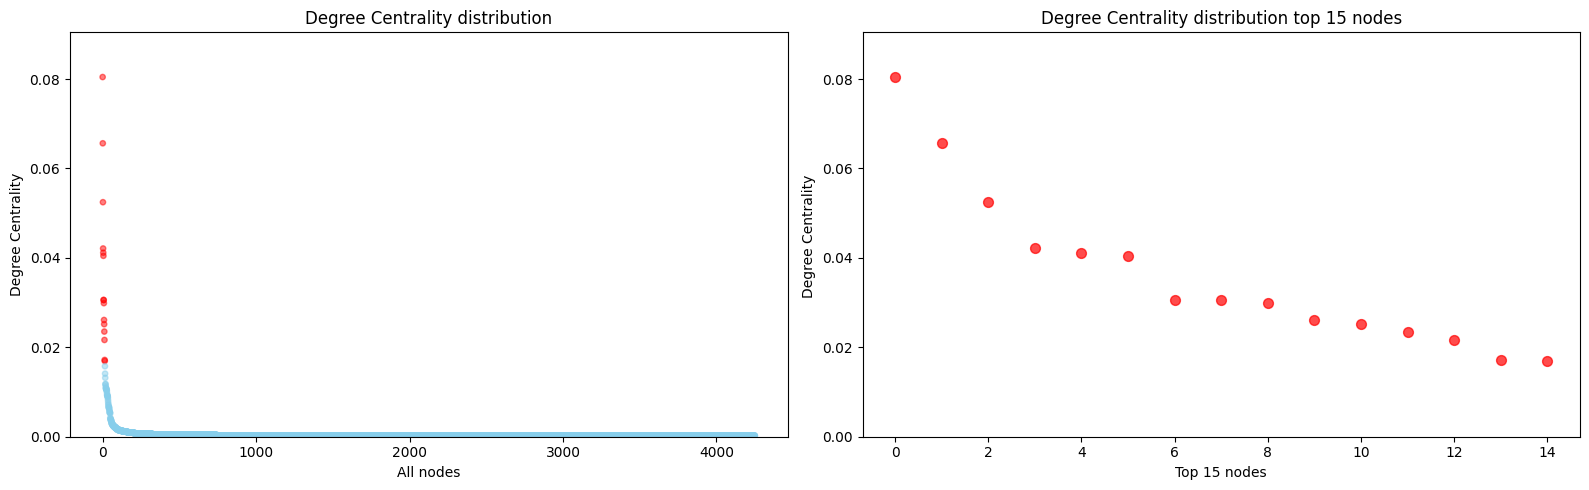

In [9]:
degree_centrality = nx.degree_centrality(G)

top_15_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:15]

print("Nodes with the highest centrality degree:")
for node, centrality in top_15_nodes:
    print(f"{round(centrality, 4)} : {node}")


sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
all_nodes_sorted = [node for node, _ in sorted_nodes]
all_degrees_sorted = [centrality for _, centrality in sorted_nodes]

top_15_set = set(node for node, _ in top_15_nodes)
colors = ["red" if node in top_15_set else "skyblue" for node in all_nodes_sorted] 

top_15_values_sorted = [centrality for _, centrality in top_15_nodes]

fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 

axs[0].scatter(range(len(all_nodes_sorted)), all_degrees_sorted, color=colors, alpha=0.5, s=15)
axs[0].set_xlabel("All nodes")
axs[0].set_ylabel("Degree Centrality")
axs[0].set_title("Degree Centrality distribution")
axs[0].set_ylim(0, max(all_degrees_sorted) + 0.01)

axs[1].scatter(range(len(top_15_values_sorted)), top_15_values_sorted, color="red", alpha=0.7, s=50)
axs[1].set_xlabel("Top 15 nodes")
axs[1].set_ylabel("Degree Centrality ")
axs[1].set_title("Degree Centrality distribution top 15 nodes")
axs[1].set_ylim(0, max(all_degrees_sorted) + 0.01)

plt.tight_layout()
plt.show()

Nodes with the highest betweenness centrality:
0.187 : hugeplace3170
0.1271 : thenrich
0.1265 : guilty_tree_8245
0.1183 : marchprofessional435
0.1171 : packofcells
0.0808 : optimumchampionship
0.0696 : heavy-mongoose1561
0.0674 : seankiely
0.0617 : emuformer5562
0.0587 : equivalentradish9189
0.0571 : quadmuschanics
0.0523 : aespinoza91
0.0509 : sea-competition5406
0.0435 : western_bear8501
0.0411 : pixelpits


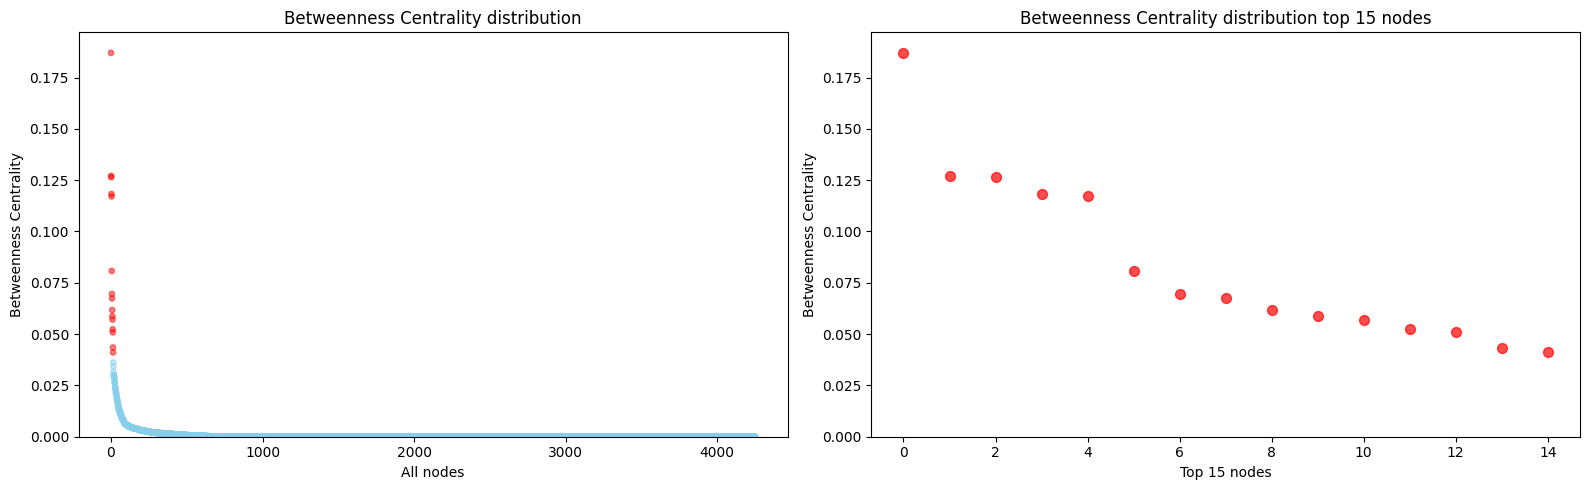

In [10]:
betweenness_centrality = nx.betweenness_centrality(G)

top_15_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:15]

print("Nodes with the highest betweenness centrality:")
for node, centrality in top_15_nodes:
    print(f"{round(centrality, 4)} : {node}")

sorted_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
all_nodes_sorted = [node for node, _ in sorted_nodes]
all_betweenness_sorted = [centrality for _, centrality in sorted_nodes]

top_15_set = set(node for node, _ in top_15_nodes)
colors = ["red" if node in top_15_set else "skyblue" for node in all_nodes_sorted] 

top_15_values_sorted = [centrality for _, centrality in top_15_nodes]

fig, axs = plt.subplots(1, 2, figsize=(16, 5)) 

axs[0].scatter(range(len(all_nodes_sorted)), all_betweenness_sorted, color=colors, alpha=0.5, s=15)
axs[0].set_xlabel("All nodes")
axs[0].set_ylabel("Betweenness Centrality")
axs[0].set_title("Betweenness Centrality distribution")
axs[0].set_ylim(0, max(all_betweenness_sorted) + 0.01)

axs[1].scatter(range(len(top_15_values_sorted)), top_15_values_sorted, color="red", alpha=0.7, s=50)
axs[1].set_xlabel("Top 15 nodes")
axs[1].set_ylabel("Betweenness Centrality")
axs[1].set_title("Betweenness Centrality distribution top 15 nodes")
axs[1].set_ylim(0, max(all_betweenness_sorted) + 0.01)

plt.tight_layout()
plt.show()

N of nodes/edges Betweenness Centrality : 122/206


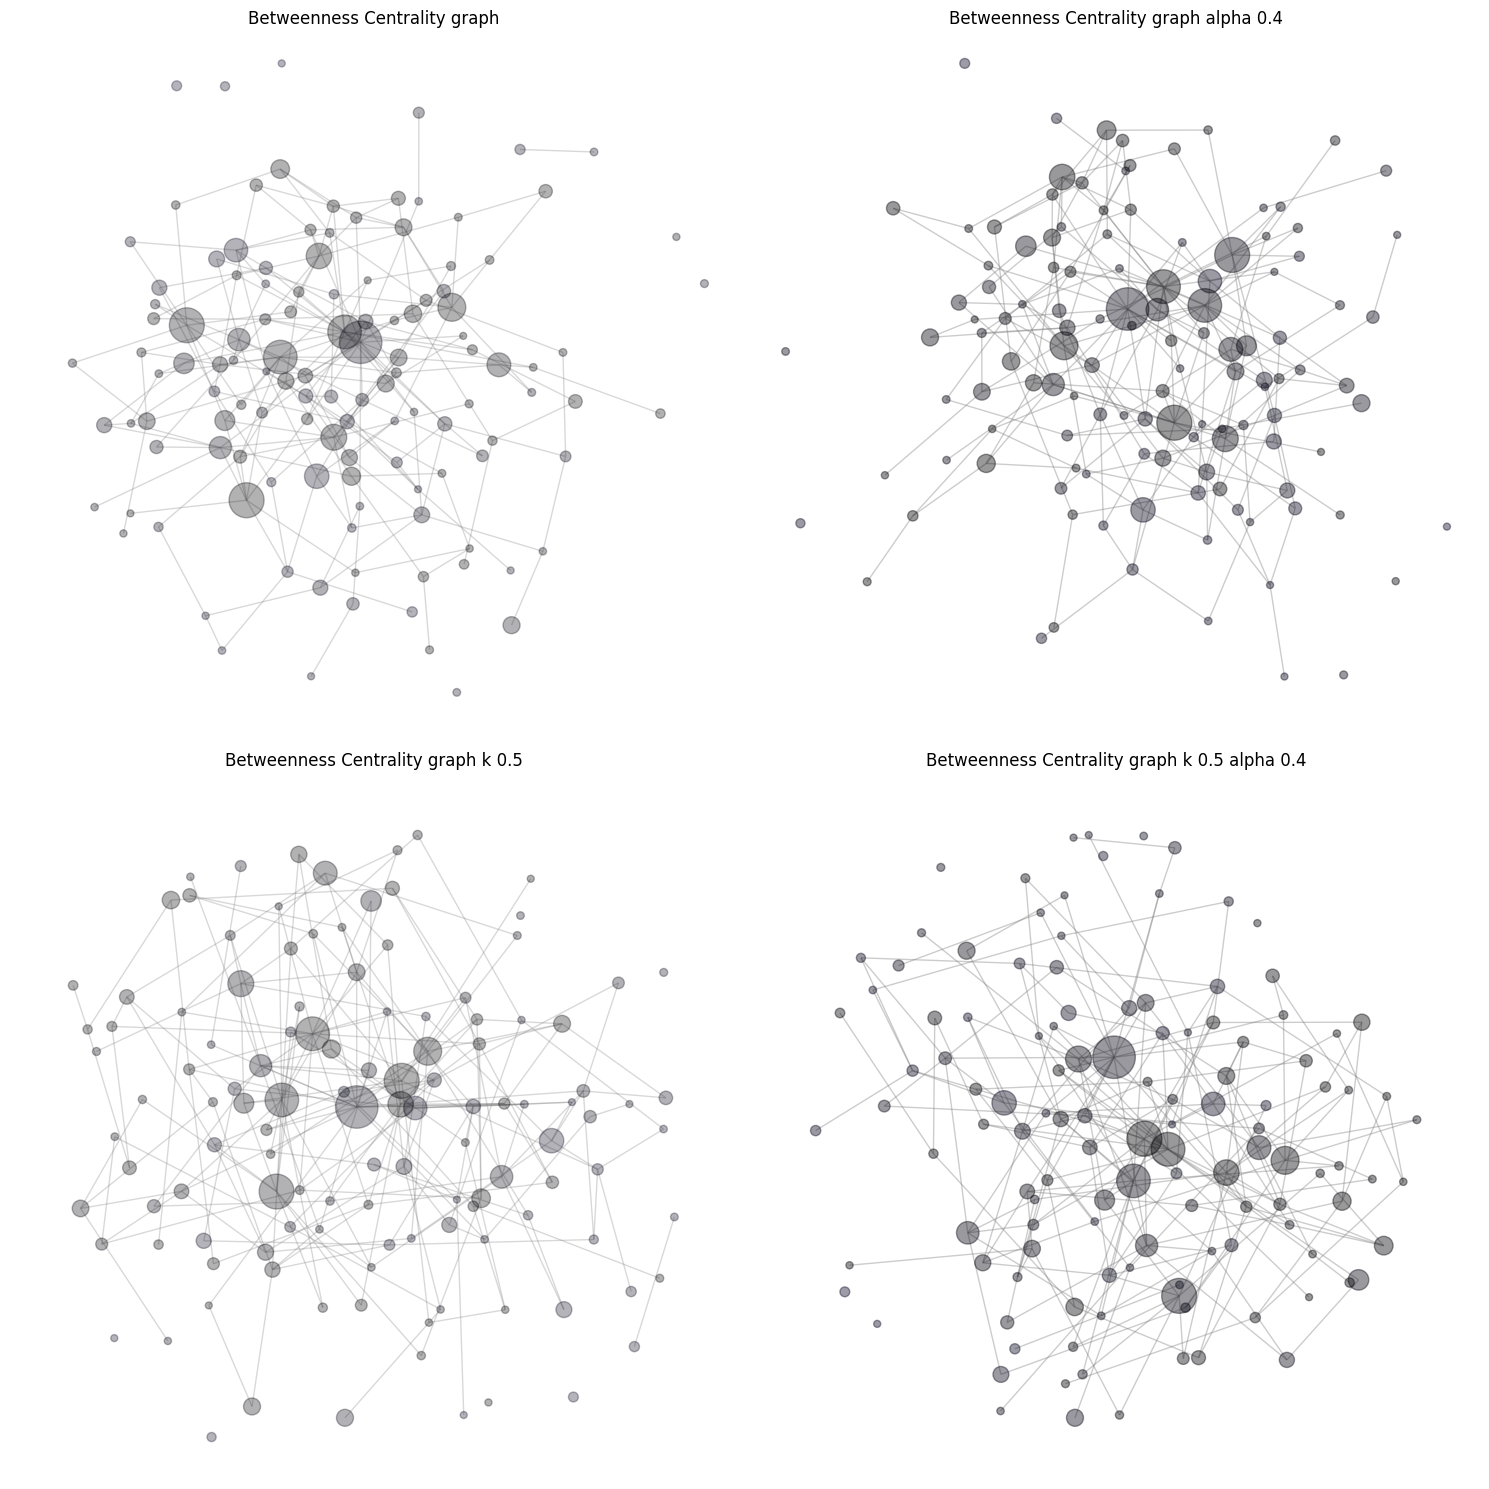

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib

# Plot 4 graphs to see which one i like the best
betweenness = nx.betweenness_centrality(G)
filtered_betweenness = [n for n, b in betweenness.items() if b > 0.005]
G_betweenness = G.subgraph(filtered_betweenness).copy()

print(f"N of nodes/edges Betweenness Centrality : {len(G_betweenness.nodes())}/{len(G_betweenness.edges())}")

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

partition_betweenness = community_louvain.best_partition(G_betweenness)
cmap_betweenness = matplotlib.colormaps["inferno"]  
node_colors_betweenness = [cmap_betweenness(partition_betweenness[node]) for node in G_betweenness.nodes()]
node_sizes_betweenness = [betweenness[node] * 5000 for node in G_betweenness.nodes()]


axs[0, 0].set_title("Betweenness Centrality graph")
pos_betweenness = nx.spring_layout(G_betweenness, k=0.3, iterations=50)
nx.draw(G_betweenness, pos_betweenness, node_size=node_sizes_betweenness, edge_color="gray", alpha=0.3, 
        node_color=node_colors_betweenness, ax=axs[0, 0])

axs[0, 1].set_title("Betweenness Centrality graph alpha 0.4")
pos_betweenness = nx.spring_layout(G_betweenness, k=0.3, iterations=50)
nx.draw(G_betweenness, pos_betweenness, node_size=node_sizes_betweenness, edge_color="gray", alpha=0.4, 
        node_color=node_colors_betweenness, ax=axs[0, 1])

axs[1, 0].set_title("Betweenness Centrality graph k 0.5")
pos_betweenness = nx.spring_layout(G_betweenness, k=0.5, iterations=50)
nx.draw(G_betweenness, pos_betweenness, node_size=node_sizes_betweenness, edge_color="gray", alpha=0.3, 
        node_color=node_colors_betweenness, ax=axs[1, 0])

axs[1, 1].set_title("Betweenness Centrality graph k 0.5 alpha 0.4")
pos_betweenness = nx.spring_layout(G_betweenness, k=0.5, iterations=50)
nx.draw(G_betweenness, pos_betweenness, node_size=node_sizes_betweenness, edge_color="gray", alpha=0.4, 
        node_color=node_colors_betweenness, ax=axs[1, 1])

plt.tight_layout()
plt.show()

N of nodes/edges Betweenness Centrality : 122/206


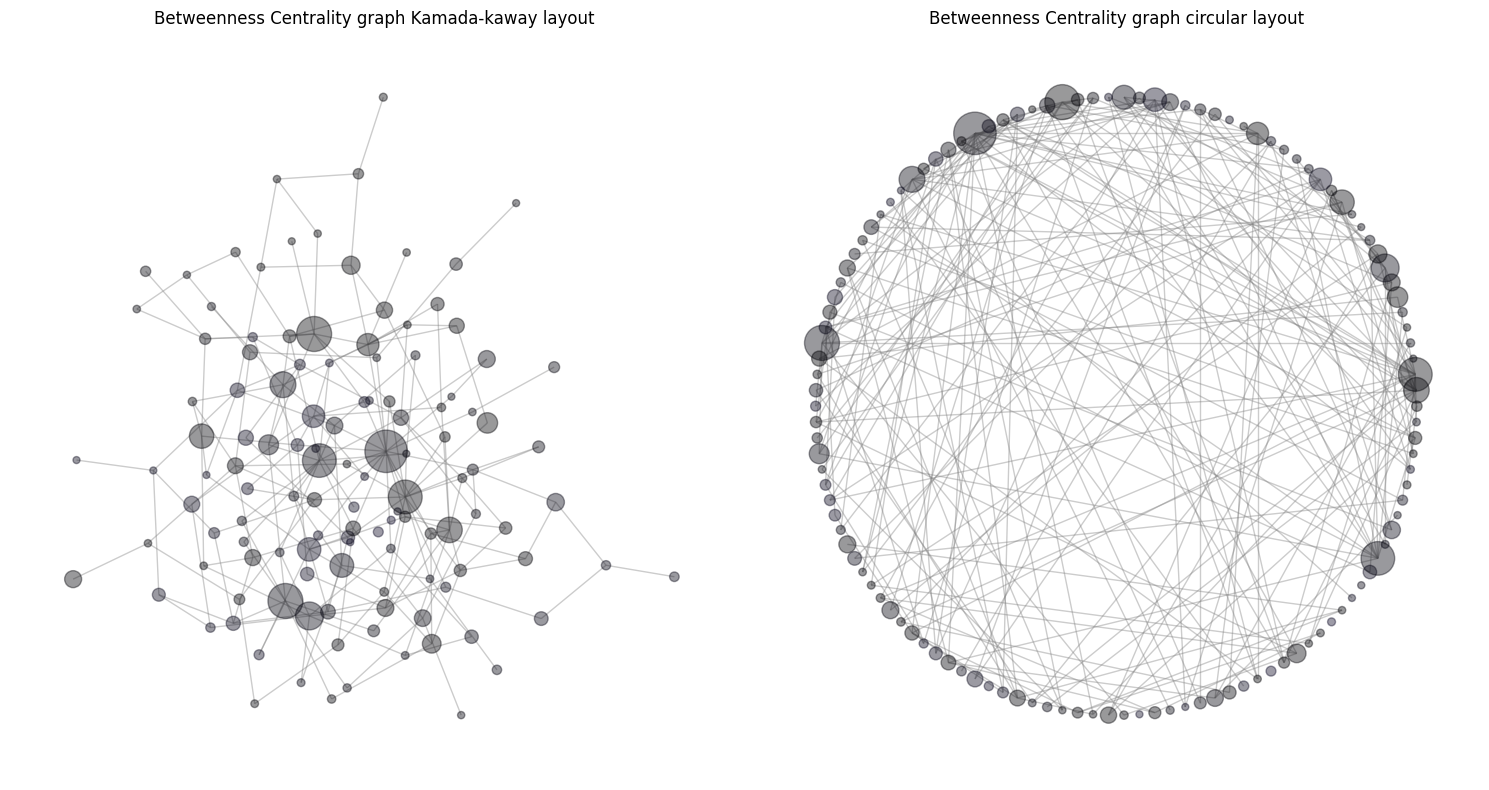

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib

betweenness = nx.betweenness_centrality(G)
filtered_betweenness = [n for n, b in betweenness.items() if b > 0.005]
G_betweenness = G.subgraph(filtered_betweenness).copy()

print(f"N of nodes/edges Betweenness Centrality : {len(G_betweenness.nodes())}/{len(G_betweenness.edges())}")

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

partition_betweenness = community_louvain.best_partition(G_betweenness)
cmap_betweenness = matplotlib.colormaps["inferno"]  
node_colors_betweenness = [cmap_betweenness(partition_betweenness[node]) for node in G_betweenness.nodes()]
node_sizes_betweenness = [betweenness[node] * 5000 for node in G_betweenness.nodes()]

axs[0].set_title("Betweenness Centrality graph Kamada-kaway layout")
pos_betweenness = nx.kamada_kawai_layout(G_betweenness)
nx.draw(G_betweenness, pos_betweenness, node_size=node_sizes_betweenness, edge_color="gray", alpha=0.4, 
        node_color=node_colors_betweenness, ax=axs[0])

axs[1].set_title("Betweenness Centrality graph circular layout")
pos_betweenness = nx.circular_layout(G_betweenness)
nx.draw(G_betweenness, pos_betweenness, node_size=node_sizes_betweenness, edge_color="gray", alpha=0.4, 
        node_color=node_colors_betweenness, ax=axs[1])

plt.tight_layout()
plt.show()

Let's try to visualize weights in the edges to show weak and strong interactions.

In [13]:
import networkx as nx
from collections import Counter

interaction_counts = Counter()

for index, row in df.iterrows():
    user = row['comment_author']
    post_author = row['post_author']
    
    if user != post_author:
        interaction_counts[(user, post_author)] += 1

G_weighted = nx.Graph()

for (user1, user2), weight in interaction_counts.items():
    G_weighted.add_edge(user1, user2, weight=weight) 

print("Number of nodes (users):", len(G.nodes))
print("Number of edges (interactions):", len(G.edges))

Number of nodes (users): 4252
Number of edges (interactions): 4691


N of nodes/edges Betweenness Centrality (Weighted) : 152/257


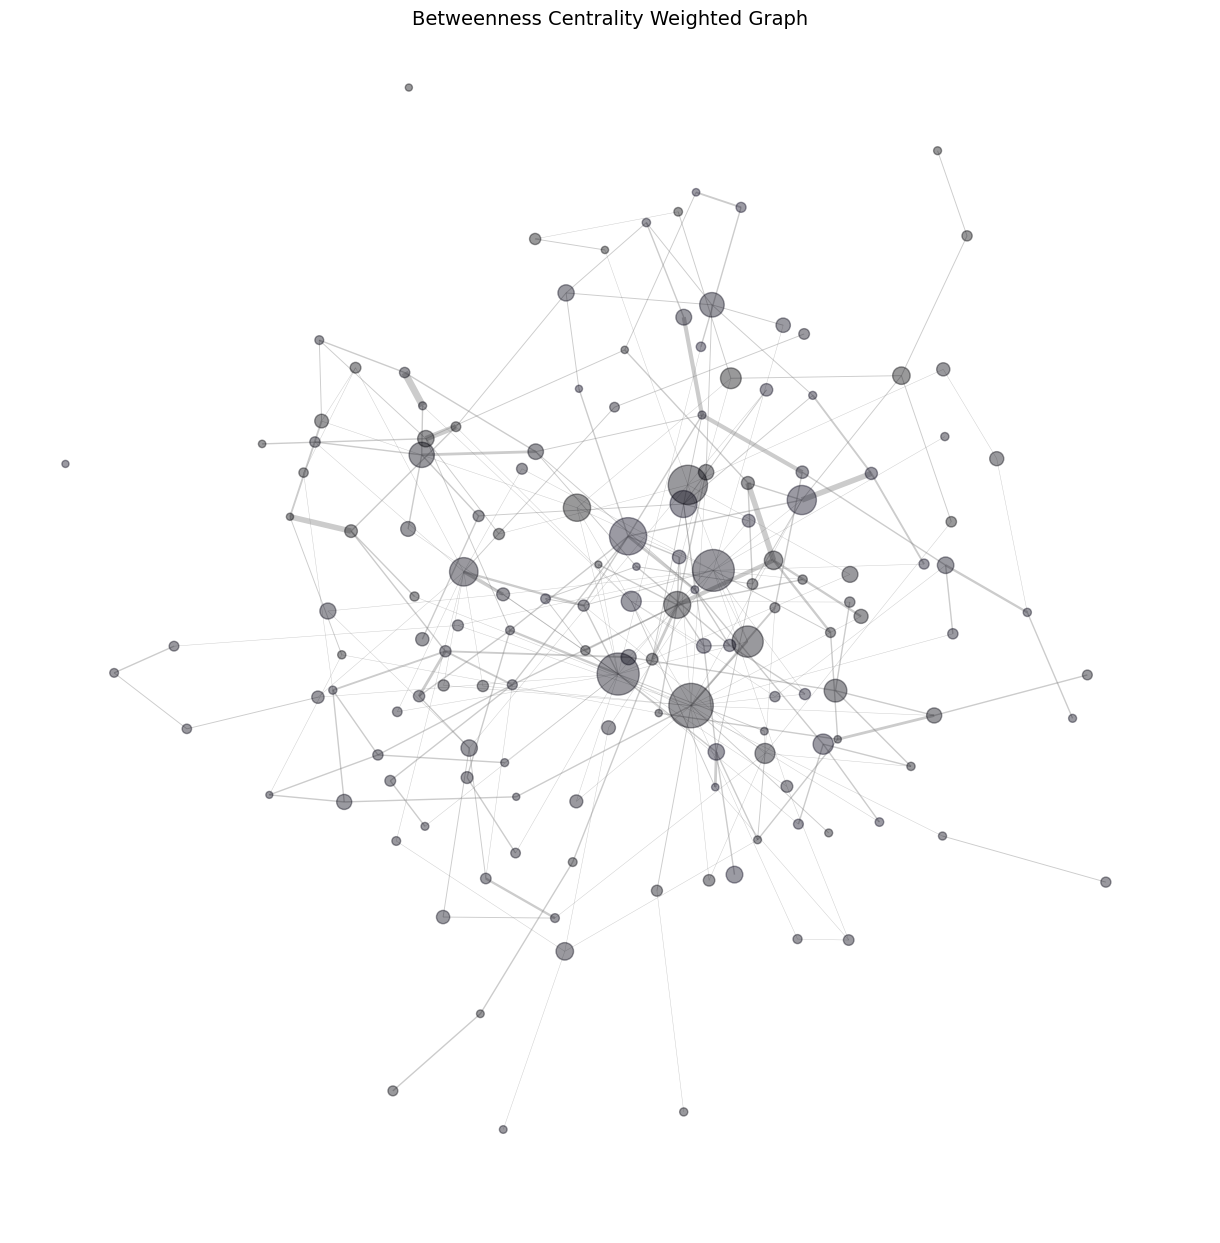

In [14]:
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib

betweenness_weighted = nx.betweenness_centrality(G_weighted, weight='weight')
filtered_betweenness_weighted = [n for n, b in betweenness_weighted.items() if b > 0.005]

G_betweenness_weighted = G_weighted.subgraph(filtered_betweenness_weighted).copy()

print(f"N of nodes/edges Betweenness Centrality (Weighted) : {len(G_betweenness_weighted.nodes())}/{len(G_betweenness_weighted.edges())}")

partition_betweenness = community_louvain.best_partition(G_betweenness_weighted)

cmap = matplotlib.colormaps["inferno"]  
node_colors = [cmap(partition_betweenness[node]) for node in G_betweenness_weighted.nodes()]
node_sizes = [betweenness_weighted[node] * 5000 for node in G_betweenness_weighted.nodes()]
edge_weights = [G_betweenness_weighted[u][v]['weight'] / max(nx.get_edge_attributes(G_betweenness_weighted, 'weight').values()) * 5 for u, v in G_betweenness_weighted.edges()]

pos = nx.spring_layout(G_betweenness_weighted, k=0.3, iterations=50)
plt.figure(figsize=(12, 12))
nx.draw(G_betweenness_weighted, pos, node_size=node_sizes, edge_color="gray", alpha=0.4, 
        node_color=node_colors, width=edge_weights)
plt.title("Betweenness Centrality Weighted Graph", fontsize=14)
plt.show()

# **Communities**

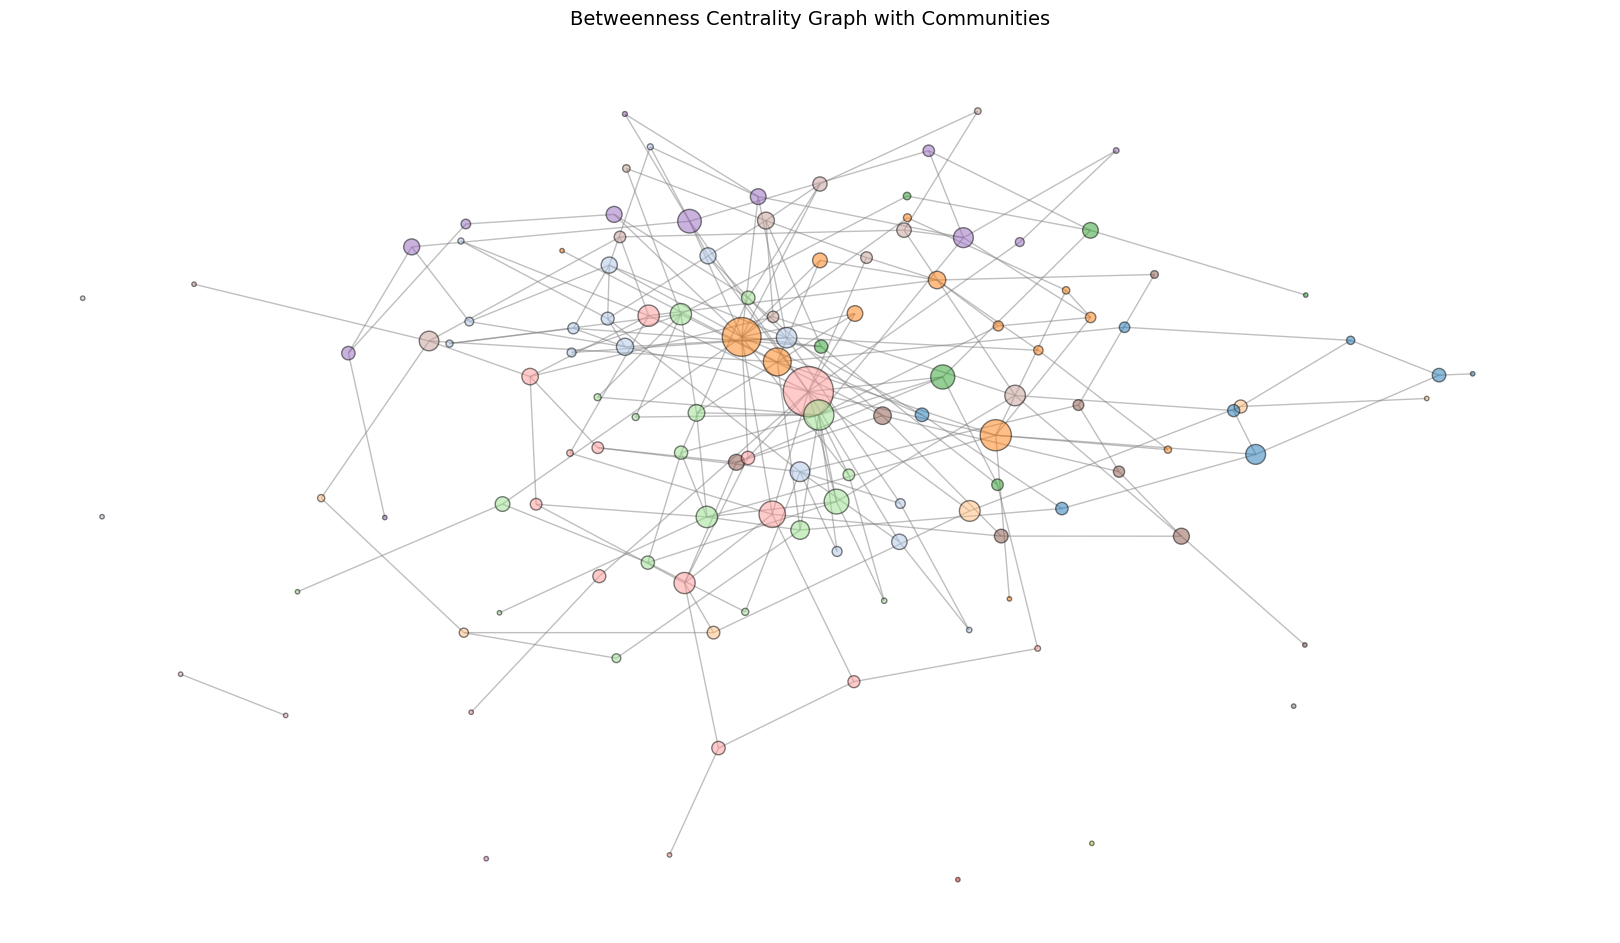

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import community as community_louvain
import matplotlib

betweenness = nx.betweenness_centrality(G)
filtered_betweenness = [n for n, b in betweenness.items() if b > 0.005]
G_betweenness = G.subgraph(filtered_betweenness).copy()

betweenness = nx.betweenness_centrality(G_betweenness)
node_sizes = [5000 * betweenness[node] + 10 for node in G_betweenness.nodes()]
partition = community_louvain.best_partition(G_betweenness)

unique_communities = list(set(partition.values()))
num_communities = len(unique_communities)
cmap = matplotlib.colormaps.get_cmap("tab20")
node_colors = [cmap(partition[node] % cmap.N) for node in G_betweenness.nodes()] 

pos = nx.spring_layout(G_betweenness, k=0.3, iterations=50)

plt.figure(figsize=(16, 9))
nx.draw(G_betweenness, pos, node_size=node_sizes, edge_color="gray", alpha=0.5, 
        node_color=node_colors, edgecolors="black")


plt.title("Betweenness Centrality Graph with Communities", fontsize=14)
plt.savefig('/kaggle/working/BetweennessCentralityGraphWithCommunities.png', dpi=300)
plt.show()

In [16]:
from collections import Counter

num_communities = len(set(partition.values()))
community_sizes = Counter(partition.values())

largest_community_size = max(community_sizes.values())

print(f"Number of communities: {num_communities}")
print(f"Biggest community size: {largest_community_size}")

Number of communities: 17
Biggest community size: 18


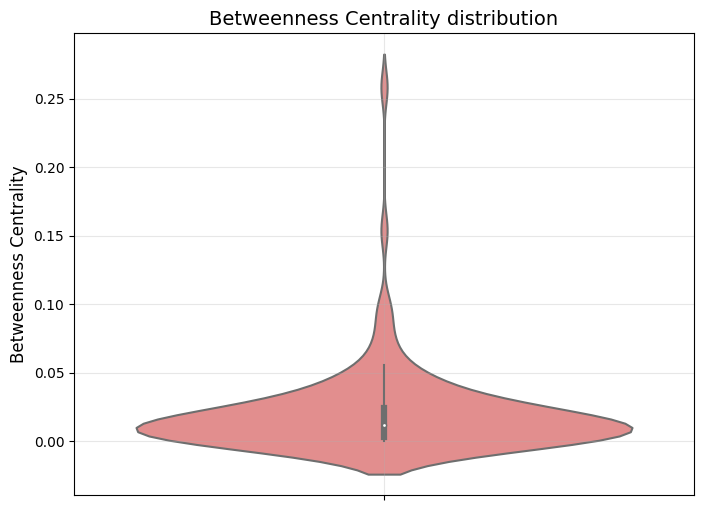

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.violinplot(y=list(betweenness.values()), color="lightcoral")

plt.title("Betweenness Centrality distribution", fontsize=14)
plt.ylabel("Betweenness Centrality", fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig('/kaggle/working/BetweennessCentralityViolinPlot.png', dpi=300)
plt.show()

# **Bipartite graph**

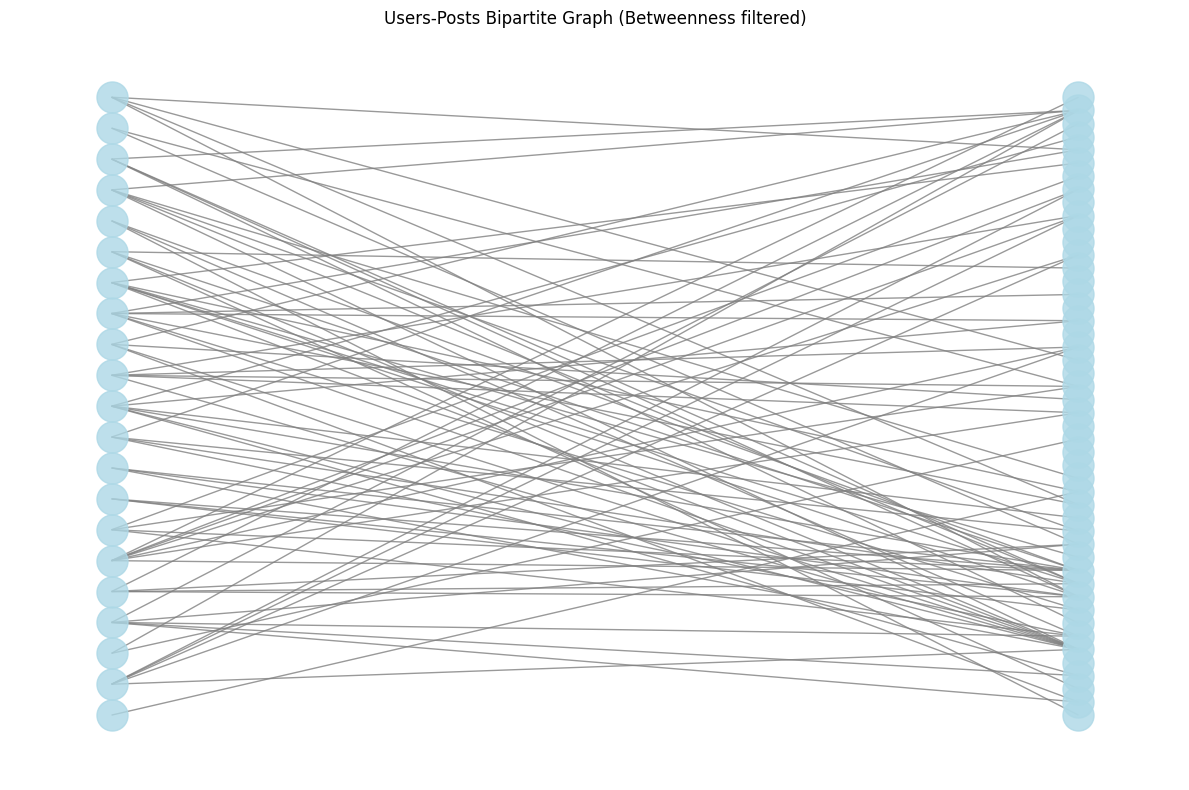

In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

B = nx.Graph()

for index, row in df.iterrows():
    user = row['comment_author']
    post = row['post_id']
    
    B.add_node(user, bipartite='user')
    B.add_node(post, bipartite='post')
    B.add_edge(user, post)

users = {n for n, d in B.nodes(data=True) if d['bipartite'] == 'user'}
posts = set(B) - users

#Filter for betweenness
betweenness = nx.betweenness_centrality(B)
nodes = {n for n, b in betweenness.items() if b > 0.01}
B = B.subgraph(nodes).copy()
filtered_users = {n for n in B if n in users}

pos = nx.bipartite_layout(B, filtered_users)

plt.figure(figsize=(12, 8))
plt.title("Users-Posts Bipartite Graph (Betweenness filtered)")
nx.draw(B, pos, node_color='lightblue', edge_color='gray', node_size=500, alpha=0.8)
plt.tight_layout()
plt.savefig('/kaggle/working/BetweennessCentralityBipartiteGraph.png', dpi=300)
plt.show()

# **Sentiment Analysis**

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
import re

nltk.download("vader_lexicon")
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))


df = pd.read_csv("/kaggle/input/reddit-tiktok-migration-csv/reddit.csv")
df = df.dropna(subset=["comment_body"])

def clean_text(text):
    if isinstance(text, str): 
        text = text.lower()  # To lowercase
        text = re.sub(r"http\S+", "", text)  # Remove URL
        text = re.sub(r"@\w+", "", text)  # Remove mentions
        text = re.sub(r"#\w+", "", text)  # Remove hashtag
        text = re.sub(r"[^a-z\s]", "", text) # keep only letters
        text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
        return text
    return ""

df["clean_comment"] = df["comment_body"].astype(str).apply(clean_text)

pd.set_option("display.max_colwidth", None)
df[["comment_body", "clean_comment"]].head(20)

/usr/local/lib/python3.10/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


comment_body  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Depends since you get another community violation you just automatically get a strike I had like 6 before I got banned then just 3 or so after that   
3                                                                                                                                                                                                           I think I had eight community violations before I got the warning. But I think I got an additional strike after the warning but now for some reason I can't find it. I did appeal all 8 of those violations and won. I do have a second account I don't use much and has had no violations and was also wondering if they'll let me keep the second account if the main one gets banned. I guess it wouldn't be the worst thing if I had to start over with the second account.   
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Paywall. Useless post.   
6                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          It never recovered from the ban.   
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      i still use it same as i did before just looking at funny videos and some political stuff but it’s all political stuff i agree with.   
8                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            I deleted it the minute they thanked Trump for saving it before he was even the presiden

In [20]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    if isinstance(text, str):  
        sentiment_score = sia.polarity_scores(text) 
        return sentiment_score["compound"]
    return 0 

df["sentiment_score"] = df["clean_comment"].apply(analyze_sentiment)

def categorize_sentiment(score):
    if score > 0.1:
        return "Positive"
    elif score < -0.1:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_label"] = df["sentiment_score"].apply(categorize_sentiment)

df[["comment_body", "sentiment_score", "sentiment_label"]].head(50)

comment_body  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Depends since you get another community violation you just automatically get a strike I had like 6 before I got banned then just 3 or so after that   
3                                                                                                                                                                                                                                                                                                                                                        I think I had eight community violations before I got the warning. But I think I got an additional strike after the warning but now for some reason I can't find it. I did appeal all 8 of those violations and won. I do have a second account I don't use much and has had no violations and was also wondering if they'll let me keep the second account if the main one gets banned. I guess it wouldn't be the worst thing if I had to start over with the second account.   
5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Paywall. Useless post.   
6                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       It never recovered from the ban.   
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   i still use it same as i did before just looking at funny vi

In [21]:
#Export the new file with the sentiment analysis
df.to_csv("reddit_sentiment_analysis.csv", index=False)

                 Count  Percentage
sentiment_label                   
Positive          6285   36.270776
Neutral           5647   32.588873
Negative          5396   31.140351


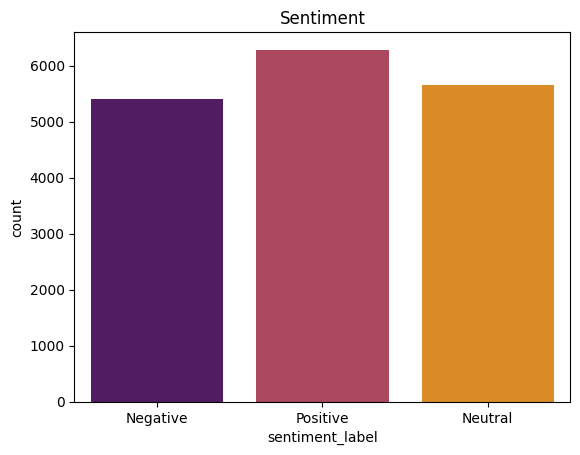

In [22]:
# Check the values

sentiment_counts = df["sentiment_label"].value_counts()
sentiment_percentages = (sentiment_counts / len(df)) * 100

sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Percentage': sentiment_percentages
})

print(sentiment_summary)

sns.countplot(x=df["sentiment_label"], palette="inferno")
plt.title("Sentiment")
plt.savefig('/kaggle/working/SentimentAnalysisBarChart.png', dpi=300)
plt.show()

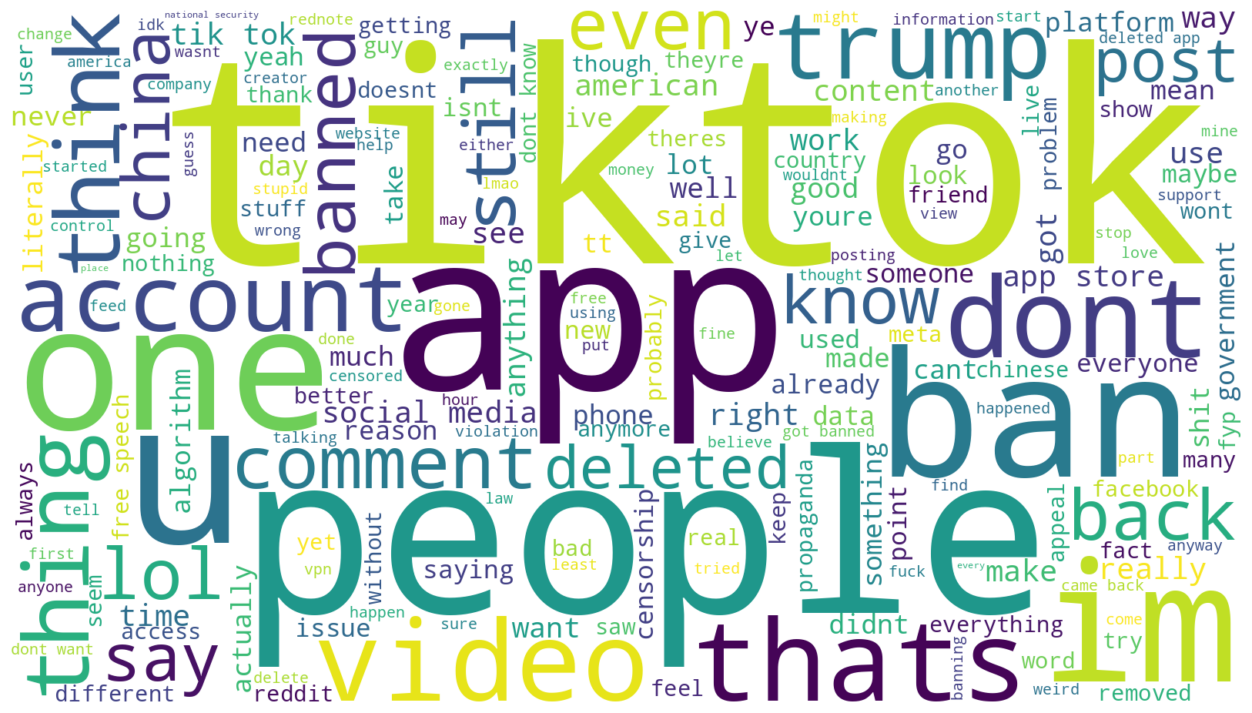

In [23]:
# Word cloud

text = " ".join(df["clean_comment"])
wordcloud = WordCloud(width=1600, height=900, background_color="white").generate(text)

plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()